## Prompt 
You've just joined the data team at an online publishing company. One of your verticals is a food publication. A product manager on your team wants to build a feature for this vertical that enables users to query by cuisine, not just by ingredients. Most of your recipes are unlabeled, and it's infeasible to label them by hand. Luckily, you have a small training set of about 10,000 recipes with labeled cuisines.
    
Design and execute a method to **predict the cuisine of a recipe given only its ingredients**. How could you design this to be robust enough to understand similarities / substitutions between ingredients? **For each major cuisine, what are the driving ingredients that characterize it?**
    
Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. How would you go about writing this guide for a few major cuisines?

## Import data set

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import data set
data_raw = pd.read_json('./recipies.json')

In [4]:
data_raw.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## Print number of unique labels (cuisines) and ingredients, look for duplicates

In [5]:
# Find number of unique cuisine labels
print('Number of recipes: ', len(data_raw['cuisine']), '\nNumber of unique cuisines: ', len(data_raw['cuisine'].unique()))

Number of recipes:  39774 
Number of unique cuisines:  20


In [6]:
# Find number of unique ingredients
ingredients = [item for sublist in data_raw['ingredients'] for item in sublist]
print('Number of ingredients: ', len(ingredients), '\nNumber of unique ingredients: ', len(set(ingredients)))

Number of ingredients:  428275 
Number of unique ingredients:  6714


In [7]:
# Check for duplicates - IDs 
print('Number of ids: ', len(data_raw), '\nNumber of unique ids: ', len(data_raw['id'].unique()))

Number of ids:  39774 
Number of unique ids:  39774


In [9]:
# Get frequency of each cuisine
cuisines = data_raw['cuisine'].value_counts().to_frame().reset_index()
cuisines.columns=['cuisine', 'frequency']
cuisines

,cuisine,frequency
0,italian,7838
1,mexican,6438
2,southern_us,4320
3,indian,3003
4,chinese,2673
5,french,2646
6,cajun_creole,1546
7,thai,1539
8,japanese,1423
9,greek,1175


## Visualize top cuisines and ingredients

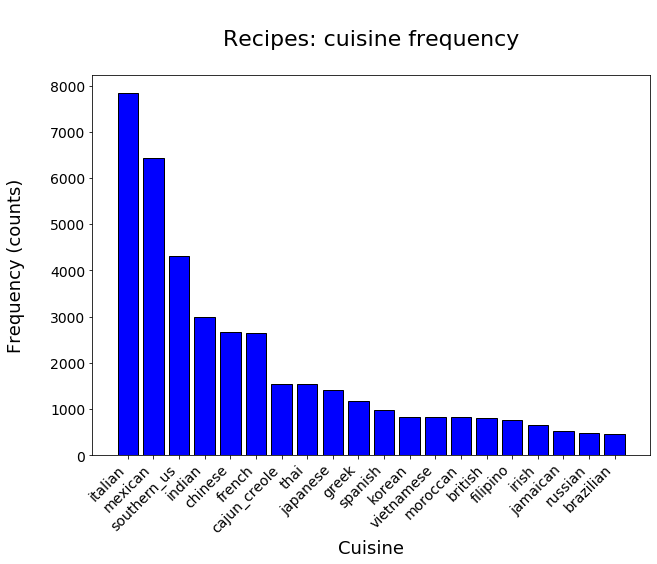

In [10]:
# Visualize cuisines by frequency in recipe data set
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(cuisines.sort_values('frequency', ascending=False)['cuisine'], 
        cuisines.sort_values('frequency', ascending=False)['frequency'], 
        color='blue', 
        edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('\nRecipes: cuisine frequency\n', size=22)
plt.xlabel('Cuisine', size=18)
plt.ylabel('Frequency (counts)\n', size=18)
ax.tick_params(labelsize=14)

In [12]:
ingredients_df = pd.DataFrame({'ingredients': ingredients})
# ingredients_df

In [13]:
ingredients_freqs = ingredients_df['ingredients'].value_counts().to_frame().reset_index()
ingredients_freqs.columns = ['ingredient', 'frequency']
# ingredients_freqs[:25]

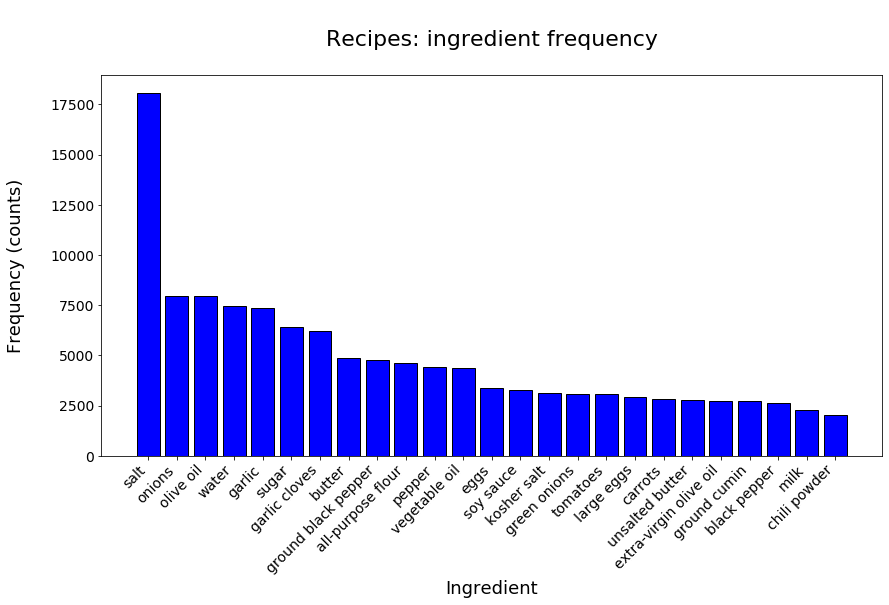

In [14]:
# Visualize ingredients by frequency in recipe data set
n = 25
fig, ax = plt.subplots(1,1,figsize=(14,7))
plt.bar(ingredients_freqs[:n].sort_values('frequency', ascending=False)['ingredient'], 
        ingredients_freqs[:n].sort_values('frequency', ascending=False)['frequency'], 
        color='blue', 
        edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('\nRecipes: ingredient frequency\n', size=22)
plt.xlabel('Ingredient', size=18)
plt.ylabel('Frequency (counts)\n', size=18)
ax.tick_params(labelsize=14)

## Feature engineering: one-hot encode categorical variables

In [15]:
# for each recipe, one-hot encode ingredients
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

cuisines = pd.DataFrame({'id': data_raw['id'], 'cuisine': data_raw['cuisine']})
# ingredients_dummies = pd.get_dummies(item for sublist in data_raw['ingredients'] for item in sublist)
ingredients_dummies = pd.DataFrame(mlb.fit_transform(data_raw['ingredients']),columns=mlb.classes_, index=data_raw.index)
recipes_dummies = cuisines.join(ingredients_dummies)

In [16]:
recipes_dummies.head()

,id,cuisine,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,10259,greek,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,southern_us,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,filipino,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# stipulate x- and y-variables
X = recipes_dummies.drop(columns=['cuisine', 'id'])
y = recipes_dummies['cuisine']

In [18]:
# # oversample - doesn't work
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X_os, y_os = oversample.fit_resample(X, y)

In [19]:
# split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

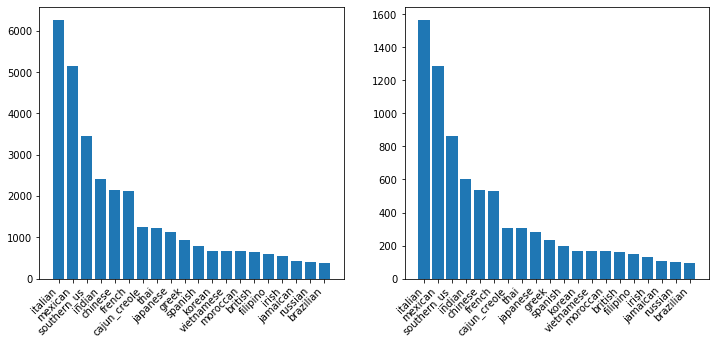

In [20]:
# check number in each group 
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].bar(x = y_train.value_counts().index, height = y_train.value_counts())
ax[0].set_xticklabels(labels = y_train.value_counts().index, rotation=45, ha='right')
ax[1].bar(x = y_test.value_counts().index, height = y_test.value_counts())
ax[1].set_xticklabels(labels = y_test.value_counts().index, rotation=45, ha='right')
plt.show()

## Modeling: Naive Bayes classifiers

In [21]:
# fit Naive Bayes classifier models
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB

In [22]:
# Bernoulli NB
model_b = BernoulliNB().fit(X_train, y_train)
y_pred_b = model_b.predict(X_test)

In [23]:
# # Categorical NB - doesn't work
# model_c = CategoricalNB().fit(X_train, y_train)
# y_pred_c = model_c.predict(X_test)

In [24]:
# Complement NB
model_c = ComplementNB().fit(X_train, y_train)
y_pred_c = model_c.predict(X_test)

In [25]:
# Gaussian NB
model_g = GaussianNB().fit(X_train, y_train)
y_pred_g = model_g.predict(X_test)

In [26]:
# Multinomial NB
model_m = MultinomialNB().fit(X_train, y_train)
y_pred_m = model_m.predict(X_test)

In [29]:
# display accuracy scores on train and test set for each
rounding = 3
from sklearn.metrics import accuracy_score
print('Bernoulli NB: train =', round(accuracy_score(y_train, model_b.predict(X_train)), rounding), ', test =', round(accuracy_score(y_test, y_pred_b), rounding))
print('Complement NB: train =', round(accuracy_score(y_train, model_c.predict(X_train)), rounding), ', test =', round(accuracy_score(y_test, y_pred_c), rounding))
print('Gaussian NB: train =', round(accuracy_score(y_train, model_g.predict(X_train)), rounding), ', test =', round(accuracy_score(y_test, y_pred_g), rounding))
print('Multinomial NB: train =', round(accuracy_score(y_train, model_m.predict(X_train)), rounding), ', test =', round(accuracy_score(y_test, y_pred_m), rounding))

Bernoulli NB: train = 0.73 , test = 0.689
Complement NB: train = 0.751 , test = 0.712
Gaussian NB: train = 0.524 , test = 0.363
Multinomial NB: train = 0.772 , test = 0.725


In [30]:
# create confusion matrices for each model
from sklearn.metrics import confusion_matrix

# Bernoulli NB
cm_b = confusion_matrix(y_test, y_pred_b)
cm_b_df = pd.DataFrame(cm_b, index = set(y_test.values), columns = set(y_test.values))

# Complement NB
cm_c = confusion_matrix(y_test, y_pred_c)
cm_c_df = pd.DataFrame(cm_c, index = set(y_test.values), columns = set(y_test.values))

# Gaussian NB
cm_g = confusion_matrix(y_test, y_pred_g)
cm_g_df = pd.DataFrame(cm_g, index = set(y_test.values), columns = set(y_test.values))

# Multinomial NB
cm_m = confusion_matrix(y_test, y_pred_m)
cm_m_df = pd.DataFrame(cm_c, index = set(y_test.values), columns = set(y_test.values))

In [56]:
# select model to examine and normalize

# cm_selected = cm_b_df
# cm_selected = cm_c_df
# cm_selected = cm_g_df
cm_selected = cm_m_df

# normalize
cm_norm = (cm_selected/cm_selected.sum()).round(1)

# alphabetize
cm_m_df

,italian,vietnamese,filipino,southern_us,japanese,thai,greek,spanish,korean,mexican,cajun_creole,chinese,british,jamaican,indian,french,irish,russian,moroccan,brazilian
italian,34,0,3,0,0,2,0,2,2,7,0,0,0,26,1,0,13,0,3,0
vietnamese,0,42,1,0,1,24,1,3,3,13,0,1,0,1,0,0,69,0,1,1
filipino,1,3,182,2,0,5,0,1,0,40,1,0,1,16,1,0,53,2,0,1
southern_us,0,1,1,495,0,3,0,4,0,4,1,2,2,4,0,0,7,0,8,3
japanese,1,0,2,40,46,0,0,7,2,10,0,2,1,7,0,0,7,1,24,1
thai,1,8,3,4,1,249,3,4,2,162,1,1,2,7,0,0,78,2,1,0
greek,0,0,1,1,0,3,111,13,1,89,0,0,0,5,2,1,8,0,0,0
spanish,0,0,0,3,0,3,1,545,0,7,1,1,0,15,4,1,13,1,5,1
korean,0,4,3,2,0,14,1,3,33,9,1,0,0,5,2,1,53,0,2,0
mexican,1,1,1,3,1,55,6,4,1,1395,1,0,1,24,1,3,66,3,1,0


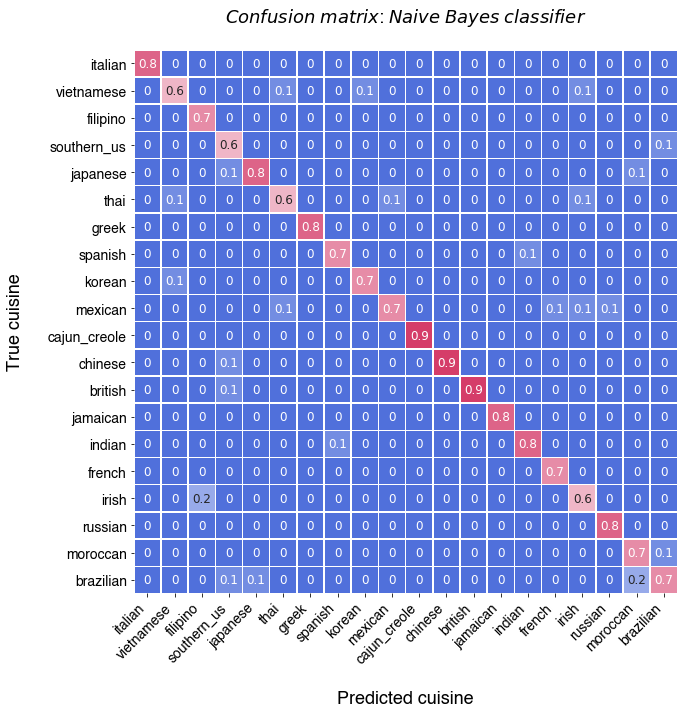

In [41]:
# plot confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(260, 0, n=9, as_cmap=True)
ax = sns.heatmap(cm_norm,
                 cmap=cmap, 
                 annot=True,
                 fmt='0.2g',
                 annot_kws={"fontsize":12},
#                  vmin=growth_log.min().min(), 
#                  vmax=growth_log.max().max(),
                 square=True, 
                 linewidths=.5, 
                 cbar=False)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14, fontname='Helvetica')
plt.setp(ax.get_yticklabels(), rotation=0, ha='right', fontsize=14, fontname='Helvetica')
plt.xlabel('\nPredicted cuisine', fontsize=18, fontname='Helvetica')
plt.ylabel('True cuisine\n', fontsize=18, fontname='Helvetica')
# ax.invert_yaxis()
ax.set_facecolor([1,1,1])
ax.set_title('$Confusion$ $matrix$: $Naive$ $Bayes$ $classifier$\n', fontsize=18, fontname='Helvetica')
plt.show()

In [57]:
n_examples = data_raw['cuisine'].value_counts()
accuracy = cm_m.diagonal()
# n_examples

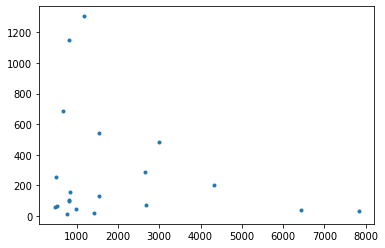

In [54]:
plt.plot(n_examples, accuracy,'.')